# Create Customer Segment Clusters using SageMaker K-Means Algorithm

In [29]:
# Step 0 - Get Role and set up S3 Bucket
from sagemaker import get_execution_role
from sagemaker.session import Session
role = get_execution_role()
bucket = Session().default_bucket()

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-874280160066


In [41]:
# Step 1 - Download Data from public repository. The data is on customer spend on various product categories
import urllib.request
urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv", "data.csv")

('data.csv', <http.client.HTTPMessage at 0x7f54b5b61f28>)

In [49]:
# Step 2 - Exploration of Data
import pandas as pd
data = pd.read_csv('data.csv')
data.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [53]:
# Drop columns not useful
data.drop(['Region', 'Channel'], axis = 1, inplace = True)

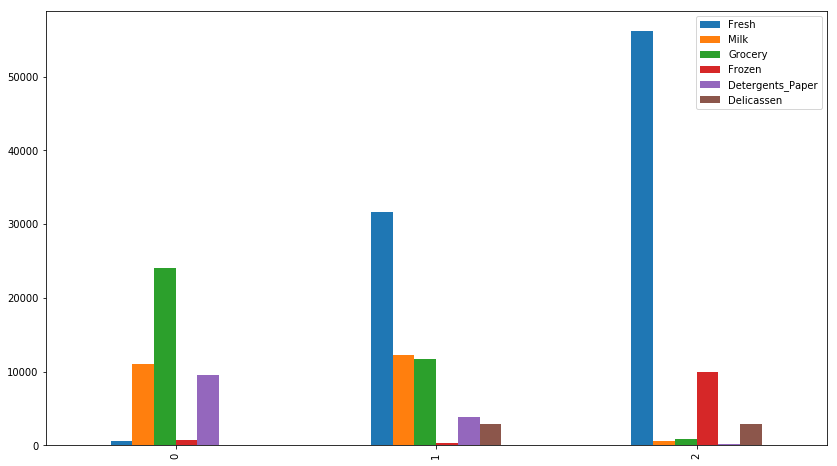

In [60]:
# Visualize some sample data
import seaborn as sns
indices = [43, 12, 39]
samples = pd.DataFrame(data.loc[indices], columns = data.columns).reset_index(drop = True)
samples.plot(kind='bar', figsize=(14,8))


In [65]:
# Step 4 - Feature engg
#We need to standardize the scaling of the numerical columns in order to use any distance based analytical methods so that we can compare the relative distances between different feature columns. 
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
data_scaled=pd.DataFrame(scaler.fit_transform(data))
data_scaled.columns=data.columns
data_scaled.index=data.index

In [66]:
#Values are between 0 & 1 now
data_scaled.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,0.106977,0.078173,0.085671,0.050078,0.070510,0.031745
std,0.112774,0.100491,0.102430,0.079789,0.116790,0.058826
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.027863,0.020124,0.023174,0.011788,0.006216,0.008453
50%,0.075802,0.048636,0.051225,0.024670,0.019927,0.020077
75%,0.150968,0.097154,0.114821,0.058005,0.095997,0.037907
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [78]:
# Step 3 - Dimensionality Reduction. Reducing from 6 to 3 features.
from sagemaker import PCA
bucket_name='sagemaker-us-east-1-874280160066'
num_components=3

pca_SM = PCA(role=role,
          train_instance_count=1,
          train_instance_type='ml.c4.xlarge',
          output_path='s3://'+ bucket_name +'/customers/',
            num_components=num_components)


INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-874280160066


In [79]:
#Prepare data for Amazon SageMaker by extracting the numpy array from the DataFrame and explicitly casting to  float32
train_data = data_scaled.values.astype('float32')

In [80]:
# Call PCA fit method

pca_SM.fit(pca_SM.record_set(train_data))

INFO:sagemaker:Creating training-job with name: pca-2018-12-14-01-03-41-891


2018-12-14 01:03:42 Starting - Starting the training job...
2018-12-14 01:03:43 Starting - Launching requested ML instances.........
2018-12-14 01:05:17 Starting - Preparing the instances for training......
2018-12-14 01:06:26 Downloading - Downloading input data..
Docker entrypoint called with argument(s): train
[12/14/2018 01:06:48 INFO 140650549040960] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[12/14/2018 01:06:48 INFO 140650549040960] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'6', u'mini_batch_size': u'440', u'num_components': u'3'}
[12/14/2018 01:06:48 INFO 140650549040960] Final configuration: {u'num_components': u'3', u'_num_gpus


2018-12-14 01:06:57 Training - Training image download completed. Training in progress.
2018-12-14 01:06:57 Uploading - Uploading generated training model
2018-12-14 01:06:57 Completed - Training job completed
Billable seconds: 31


In [82]:
#Access the Mode
import boto3
import os

job_name='pca-2018-12-14-01-03-41-891'
model_key = "customers/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

2304

In [100]:

import mxnet as mx
pca_model_params = mx.ndarray.load('model_algo-1')

In [101]:
#
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())


In [123]:
# We see that 2 components explain ~88% of the total variance in our dataset:
s.iloc[1:,:].apply(lambda x: x*x).sum()/s.apply(lambda x: x*x).sum()

0    0.880779
dtype: float32

In [132]:
s_2=s.iloc[1:,:]
v_2=v.iloc[:,1:]
v_2.columns=[0,1]

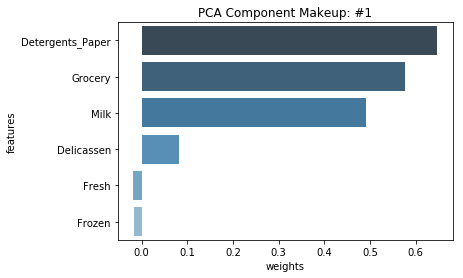

In [137]:
#We can now examine the makeup of each PCA component based on the weightings of the original features that are included in the component. 
import numpy as np
component_num=1
first_comp = v_2[2-component_num]
comps = pd.DataFrame(list(zip(first_comp, data_scaled.columns)), columns=['weights', 'features'])
comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
ax=sns.barplot(data=comps.sort_values('abs_weights', ascending=False).head(10), x="weights", y="features", palette="Blues_d")
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

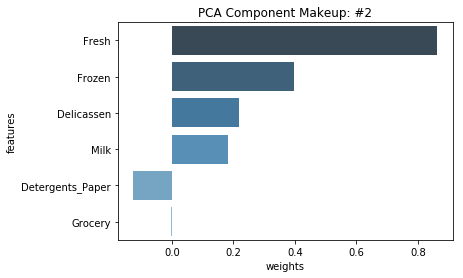

In [138]:
#We can now examine the makeup of each PCA component based on the weightings of the original features that are included in the component. 
import numpy as np
component_num=2
first_comp = v_2[2-component_num]
comps = pd.DataFrame(list(zip(first_comp, data_scaled.columns)), columns=['weights', 'features'])
comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
ax=sns.barplot(data=comps.sort_values('abs_weights', ascending=False).head(10), x="weights", y="features", palette="Blues_d")
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

In [140]:
# Deploying PCA Model
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

INFO:sagemaker:Creating model with name: pca-2018-12-14-01-57-00-498
INFO:sagemaker:Creating endpoint with name pca-2018-12-14-01-03-41-891


--------------------------------------------------------------------------------------!

In [141]:
# We can also pass our original dataset to the model so that we can transform the data using the model we created. 
# Then we can take the largest 2 components and this will reduce the dimensionality of our data from 5 to 2.
result = pca_predictor.predict(train_data)

In [144]:
PCA_list=['comp_1', 'comp_2']
data_transformed=pd.DataFrame()
for a in result:
    b=a.label['projection'].float32_tensor.values
    data_transformed=data_transformed.append([list(b)])
data_transformed.index=data_scaled.index
data_transformed=data_transformed.iloc[:,1:]
data_transformed.columns=PCA_list
data_transformed.head()

#Now we have created a dataset where each customer is described by the 2 principle components 
#that we analyzed earlier. Each of these 2 components is a linear combination of the original feature space. 
#We can interpret each of these 2 components by analyzing the makeup of the component shown previously.

,comp_1,comp_2
0,-0.004124,0.020446
1,-0.036889,0.045003
2,-0.013746,0.040474
3,0.028786,-0.092295
4,0.106330,-0.020514


In [155]:
# Step4 - Clustering using KMeans alogorithm
train_data = data_transformed.values.astype('float32')

In [171]:
# Define Hyperparameter. Number of clusters=7
from sagemaker import KMeans

num_clusters = 3
kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path='s3://'+ bucket +'/customer/',              
                k=num_clusters)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-874280160066


In [172]:
# Train the Model
kmeans.fit(kmeans.record_set(train_data))

INFO:sagemaker:Creating training-job with name: kmeans-2018-12-14-16-58-42-258


2018-12-14 16:58:42 Starting - Starting the training job...
2018-12-14 16:58:43 Starting - Launching requested ML instances......
2018-12-14 16:59:44 Starting - Preparing the instances for training.........
2018-12-14 17:01:37 Downloading - Downloading input data
2018-12-14 17:01:37 Training - Training image download completed. Training in progress.
2018-12-14 17:01:37 Uploading - Uploading generated training model
Docker entrypoint called with argument(s): train
[12/14/2018 17:01:33 INFO 140043993716544] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': 


2018-12-14 17:01:44 Completed - Training job completed
Billable seconds: 26


In [173]:
# Deploy the Model

%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

INFO:sagemaker:Creating model with name: kmeans-2018-12-14-17-02-28-865


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


INFO:sagemaker:Creating endpoint with name kmeans-2018-12-14-16-58-42-258


---------------------------------------------------------------------------!

In [174]:
# Validate that endpoint works
result = kmeans_predictor.predict(train_data[100:300])
print(result)

[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 0.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.16027827560901642
    }
  }
}
, label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 0.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.18220709264278412
    }
  }
}
, label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 0.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.06447171419858932
    }
  }
}
, label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 1.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.2929346263408661
    }
  }
}
, label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 0.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


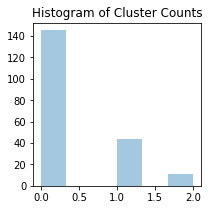

In [175]:
# Distribution of Clusters
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]
pd.DataFrame(cluster_labels)[0].value_counts()
ax=plt.subplots(figsize=(3,3))
ax=sns.distplot(cluster_labels, kde=False)
title="Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

In [178]:
# Step5 - Drawing Conclusion from our Modelling
# Accessing KMeans Model attributes
job_name='kmeans-2018-12-14-16-58-42-258'
model_key = "customer/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')
Kmeans_model_params = mx.ndarray.load('model_algo-1')

In [179]:
#Cluster Centroid Locations: The location of the centers of each cluster identified by the Kmeans algorithm. 
#The cluster location is given in our PCA transformed space with 2 components, since we passed the transformed PCA data into the model.
cluster_centroids=pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns=data_transformed.columns
cluster_centroids

,comp_1,comp_2
0,-0.054385,-0.029247
1,0.147280,-0.047066
2,-0.024406,0.473826



We can plot a heatmap of the centroids and their location in the transformed feature space. This gives us insight into what characteristics define each cluster. Often with unsupervised learning, results are hard to interpret. This is one way to make use of the results of PCA plus clustering techniques together. Since we were able to examine the makeup of each PCA component, we can understand what each centroid represents in terms of the PCA components that we intepreted previously.


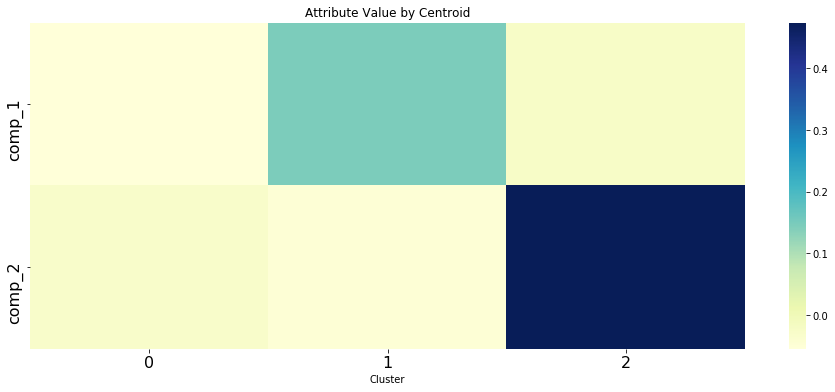

In [180]:
plt.figure(figsize = (16, 6))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

In [ ]:
# Delete end points
sagemaker.Session().delete_endpoint(pca_predictor.endpoint)
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)